# Unsupervised Clustering of champions using K-means algorithm


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

os.chdir("..")
from data_parser import ALL_CHAMPION_BASE_STATS

## Data preparation
The champions' data is converted to a Pandas dataframe

In [2]:
print(ALL_CHAMPION_BASE_STATS["Aatrox"])
print(type(ALL_CHAMPION_BASE_STATS))

{'health': 650, 'health_perlevel': 114, 'mana': 0, 'mana_perlevel': 0, 'move_speed': 345, 'armor': 38, 'armor_perlevel': 4.45, 'magic_resist': 32, 'magic_resist_perlevel': 2.05, 'attack_range': 175, 'health_regen': 3, 'health_regen_perlevel': 1, 'mana_regen': 0, 'mana_regen_perlevel': 0, 'crit_chance': 0, 'crit_chance_perlevel': 0, 'attack_damage': 60, 'attack_damage_perlevel': 5, 'attack_speed_perlevel': 2.5, 'attack_speed': 0.651}
<class 'dict'>


In [3]:
df = pd.DataFrame.from_dict(ALL_CHAMPION_BASE_STATS)
df = pd.DataFrame.transpose(df)
df.head()

,health,health_perlevel,mana,mana_perlevel,move_speed,armor,armor_perlevel,magic_resist,magic_resist_perlevel,attack_range,health_regen,health_regen_perlevel,mana_regen,mana_regen_perlevel,crit_chance,crit_chance_perlevel,attack_damage,attack_damage_perlevel,attack_speed_perlevel,attack_speed
Aatrox,650.0,114.0,0.0,0.0,345.0,38.0,4.45,32.0,2.05,175.0,3.00,1.00,0.0,0.0,0.0,0.0,60.0,5.00,2.500,0.651
Ahri,570.0,96.0,418.0,25.0,330.0,18.0,4.70,30.0,1.30,550.0,2.50,0.60,8.0,0.8,0.0,0.0,53.0,3.00,2.000,0.668
Akali,570.0,119.0,200.0,0.0,345.0,23.0,4.70,37.0,2.05,125.0,9.00,0.90,50.0,0.0,0.0,0.0,62.0,3.30,3.200,0.625
Akshan,630.0,104.0,350.0,40.0,330.0,26.0,4.20,30.0,1.30,500.0,3.75,0.65,8.2,0.7,0.0,0.0,52.0,3.50,4.000,0.638
Alistar,670.0,120.0,350.0,40.0,330.0,44.0,4.70,32.0,2.05,125.0,8.50,0.85,8.5,0.8,0.0,0.0,62.0,3.75,2.125,0.625


The stats of champions are calculated according to their level

In [4]:
level = 18
df["max_health"] = df["health"] + df["health_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_mana"] = df["mana"] + df["mana_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_armor"] = df["armor"] + df["armor_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_magic_resist"] = df["magic_resist"] + df["magic_resist_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_attack_damage"] = df["attack_damage"] + df["attack_damage_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))
df["max_attack_speed"] = df["attack_speed"] * (
    1 + df["attack_speed_perlevel"] * (level - 1) * (0.7025 + 0.0175 * (level - 1))/100
)

Check if the formulas are correct :

In [5]:
from champions import Ahri

ahri = Ahri(level=18)
assert ahri.orig_base_stats.attack_speed == df.at["Ahri","max_attack_speed"]
assert ahri.orig_base_stats.health == df.at["Ahri","max_health"]
assert ahri.orig_base_stats.attack_damage == df.at["Ahri","max_attack_damage"]
print("check passed")

check passed


Additional data can be computed from existing stats: dps and effective armor/mr

In [6]:
df["base_max_dps"] = df["max_attack_damage"] * df["max_attack_speed"]
df["base_max_physical_effective_health"] = df["max_health"] * df["max_armor"]/100
df["base_max_magical_effective_health"] = df["max_health"] * df["max_magic_resist"]/100

In [7]:
df.at["Jhin","max_attack_speed"]

0.625

Data for K-means algorithm is scaled and weighted.\
for one stat, the scaling attributes 1 to the max value, and 0 to the min value.
To find which champions can play as adc, the chosen weights are 0.3 for max_attack_damage, 1 for max_attack_speed, and 0.7 for range. This is because items increase AD by a large flat amount, but attack speed scales with %.

In [9]:
scaler = MinMaxScaler()

scaler.fit(df[["max_health"]])
df["max_health"] = scaler.transform(df[["max_health"]])

scaler.fit(df[["max_mana"]])
df["max_mana"] = scaler.transform(df[["max_mana"]])

scaler.fit(df[["max_armor"]])
df["max_armor"] = scaler.transform(df[["max_armor"]])

scaler.fit(df[["max_magic_resist"]])
df["max_magic_resist"] = scaler.transform(df[["max_magic_resist"]])

scaler.fit(df[["max_attack_damage"]])
df["max_attack_damage"] = 0.3 * scaler.transform(df[["max_attack_damage"]])

scaler.fit(df[["max_attack_speed"]])
df["max_attack_speed"] = scaler.transform(df[["max_attack_speed"]])

scaler.fit(df[["attack_range"]])
df["attack_range"] = 0.7 * scaler.transform(df[["attack_range"]])

scaler.fit(df[["base_max_dps"]])
df["base_max_dps"] = scaler.transform(df[["base_max_dps"]])

scaler.fit(df[["base_max_physical_effective_health"]])
df["base_max_physical_effective_health"] = scaler.transform(df[["base_max_physical_effective_health"]])

scaler.fit(df[["base_max_magical_effective_health"]])
df["base_max_magical_effective_health"] = scaler.transform(df[["base_max_magical_effective_health"]])




## K-means algorithm : which champions can play ADC
### finding a correct number of clusters
The "elbow algorithm" is applied to find a correct guess for the number of clusters K. The idea is ton compute the sum of squared errors (sse) for various K, and pick K where lower values of K increase the sse substantially, and higher values of K only decrease the sse by a little amount.

[15.889209592278425, 5.316320654425928, 3.524385118640303, 2.139822685203651, 1.7690725442355753, 1.4502638561671624, 1.250152007109612, 1.0954710573652495, 0.9628637551532162, 0.8835125598953525, 0.8114092073906473, 0.7446217496232316, 0.6837280717240793, 0.6605702710614241, 0.6250823335420219, 0.5920849642291582, 0.5434990669168538, 0.5360940774137262, 0.49908198044382146, 0.47062068366557275, 0.44820616586222234, 0.429073991590682, 0.42427671052201604, 0.3959718143872168, 0.3768912783443676, 0.3474061365389649, 0.34377242635549066, 0.3207240801111041, 0.30997648292469004]


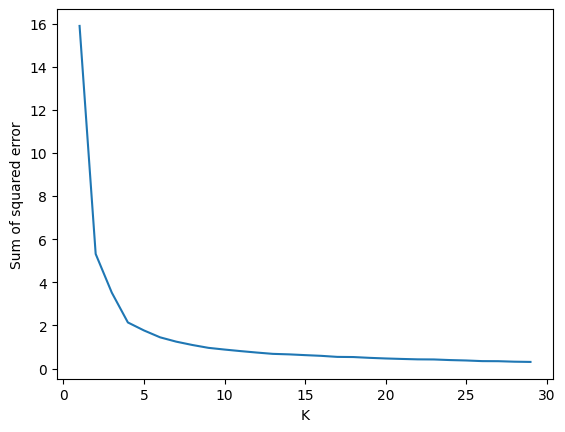

In [43]:
k_range = range(1,30)
sse =[]
for k in k_range:
    km = KMeans(n_clusters=k)
    #km.fit(df[["max_health","max_mana", "max_armor", "max_magic_resist", "max_attack_damage", "max_attack_speed"]])
    km.fit(df[["max_attack_speed", "max_attack_damage", "attack_range"]])
    sse.append(km.inertia_)

plt.xlabel("K")
plt.ylabel("Sum of squared error")
plt.plot(k_range,sse)
print(sse)

### K-means algorithm
We choose K = 8

In [26]:
km = KMeans(n_clusters=8)

prediction = km.fit_predict(df[["max_attack_speed", "max_attack_damage", "attack_range"]])

df["cluster"] = prediction

df2 = df[["base_max_dps", "max_attack_damage", "max_attack_speed", "attack_range", "cluster"]]


Let's display the clusters

In [27]:
pd.set_option("display.max_rows", None)
df2.loc[df["cluster"] == 0]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Akshan,0.661984,0.179126,0.700925,0.500000,0
Ashe,0.592518,0.172282,0.636069,0.633333,0
Azir,0.409948,0.144466,0.500000,0.533333,0
Draven,0.687069,0.213204,0.573586,0.566667,0
Ivern,0.495321,0.148544,0.613697,0.466667,0
Janna,0.441647,0.154369,0.500000,0.500000,0
Kennen,0.570143,0.179854,0.566667,0.566667,0
Kindred,0.540019,0.167476,0.583333,0.500000,0
KogMaw,0.564805,0.185534,0.532678,0.500000,0
Lucian,0.556712,0.172718,0.581832,0.500000,0


In [28]:
df2.loc[df["cluster"] == 1]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Akali,0.607219,0.198350,0.533333,0.000000,1
Amumu,0.653293,0.196893,0.601979,0.000000,1
Braum,0.591482,0.173010,0.630871,0.000000,1
Fiora,0.787456,0.215825,0.690761,0.033333,1
Fizz,0.563288,0.171845,0.595711,0.066667,1
Gangplank,0.806171,0.238835,0.613258,0.000000,1
Garen,0.907134,0.269417,0.608333,0.066667,1
Jax,0.876242,0.262864,0.598845,0.000000,1
Jayce,0.720559,0.222087,0.578165,0.000000,1
Kassadin,0.771863,0.219320,0.654996,0.033333,1


In [29]:
df2.loc[df["cluster"] == 2]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Anivia,0.317990,0.161359,0.280000,0.633333,2
Annie,0.150730,0.131214,0.137827,0.666667,2
AurelionSol,0.328199,0.178835,0.226667,0.566667,2
Brand,0.302353,0.168932,0.226667,0.566667,2
Cassiopeia,0.315595,0.157282,0.293310,0.566667,2
Elise,0.330541,0.163107,0.291667,0.566667,2
Graves,0.401607,0.250485,0.094039,0.400000,2
Heimerdinger,0.255982,0.151165,0.226667,0.566667,2
Jhin,0.338969,0.258932,0.000000,0.566667,2
Jinx,0.325113,0.194563,0.166667,0.533333,2


In [30]:
df2.loc[df["cluster"] == 3]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Alistar,0.538257,0.220631,0.354167,0.000000,3
Belveth,0.227856,0.113301,0.352941,0.066667,3
Blitzcrank,0.411416,0.208252,0.235082,0.000000,3
Chogath,0.560440,0.263301,0.240000,0.000000,3
Darius,0.557724,0.288350,0.166667,0.066667,3
Diana,0.403243,0.168932,0.375000,0.033333,3
Galio,0.399585,0.199515,0.250000,0.033333,3
Kayle,0.198118,0.123786,0.250000,0.066667,3
Mordekaiser,0.413245,0.230097,0.166667,0.066667,3
Nautilus,0.436912,0.195437,0.315325,0.066667,3


In [31]:
df2.loc[df["cluster"] == 4]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Caitlyn,0.912220,0.223107,0.814243,0.700000,4
Kalista,1.000000,0.219903,0.941035,0.533333,4
Varus,0.789635,0.203301,0.753631,0.600000,4


In [32]:
df2.loc[df["cluster"] == 5]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
DrMundo,0.819278,0.205340,0.782620,0.000000,5
Ekko,0.637804,0.171845,0.704264,0.000000,5
Gnar,0.828343,0.168932,1.000000,0.066667,5
Malphite,0.972901,0.233010,0.841424,0.000000,5
Maokai,0.773405,0.204175,0.727843,0.000000,5
Sejuani,0.934010,0.244660,0.740957,0.033333,5
Shen,0.724863,0.177670,0.798447,0.000000,5
Yasuo,0.700415,0.177670,0.763475,0.066667,5


In [33]:
df2.loc[df["cluster"] == 6]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Aatrox,0.810194,0.276699,0.474784,0.066667,6
Camille,0.637253,0.225728,0.459137,0.000000,6
Evelynn,0.482813,0.180583,0.439402,0.000000,6
Gragas,0.591886,0.214078,0.447431,0.000000,6
Gwen,0.555661,0.186408,0.515961,0.033333,6
Hecarim,0.616954,0.205049,0.517255,0.066667,6
Illaoi,0.827509,0.300000,0.416667,0.000000,6
Irelia,0.709583,0.241748,0.485961,0.100000,6
JarvanIV,0.609583,0.209126,0.490431,0.066667,6
KSante,0.567958,0.214078,0.416667,0.066667,6


In [35]:
df2.loc[df["cluster"] == 7]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
Ahri,0.401008,0.157282,0.423718,0.566667,7
Aphelios,0.390797,0.163107,0.381929,0.566667,7
Bard,0.333535,0.154369,0.333333,0.500000,7
Corki,0.380862,0.153204,0.411699,0.566667,7
Ezreal,0.383192,0.152913,0.416667,0.566667,7
Fiddlesticks,0.320680,0.145777,0.351667,0.473333,7
Kaisa,0.254074,0.125243,0.338924,0.533333,7
Karma,0.401181,0.166311,0.383333,0.533333,7
Karthus,0.330747,0.149272,0.351667,0.433333,7
Lulu,0.259839,0.120000,0.375000,0.566667,7


Top ADCs (according to champion stats) are Caitlyn, Varus, and Kalista.\
There are several champions who have good ADC stats :\
Azir, Ivern, Janna, Kennen, Neeko, Nidalee, Orianna, Teemo, Thresh, Twisted Fate, Urgot

Plotting the clusters :

Text(0, 0.5, 'attack speed')

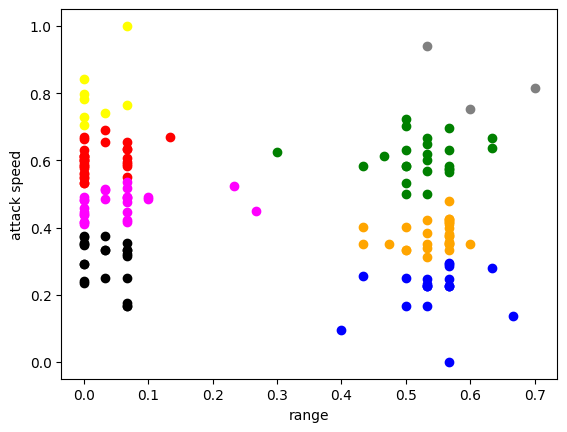

In [36]:
df2_0 = df2[df.cluster == 0]
df2_1 = df2[df.cluster == 1]
df2_2 = df2[df.cluster == 2]
df2_3 = df2[df.cluster == 3]
df2_4 = df2[df.cluster == 4]
df2_5 = df2[df.cluster == 5]
df2_6 = df2[df.cluster == 6]
df2_7 = df2[df.cluster == 7]


plt.scatter(df2_0.attack_range, df2_0.max_attack_speed, color = 'green')
plt.scatter(df2_1.attack_range, df2_1.max_attack_speed, color = 'red')
plt.scatter(df2_2.attack_range, df2_2.max_attack_speed, color = 'blue')
plt.scatter(df2_3.attack_range, df2_3.max_attack_speed, color = 'black')
plt.scatter(df2_4.attack_range, df2_4.max_attack_speed, color = 'gray')
plt.scatter(df2_5.attack_range, df2_5.max_attack_speed, color = 'yellow')
plt.scatter(df2_6.attack_range, df2_6.max_attack_speed, color = 'magenta')
plt.scatter(df2_7.attack_range, df2_7.max_attack_speed, color = 'orange')

plt.xlabel('range')
plt.ylabel('attack speed')


Text(0, 0.5, 'attack damage')

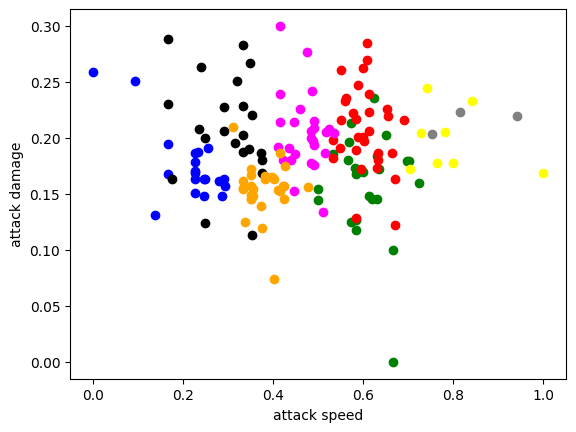

In [40]:
plt.scatter(df2_0.max_attack_speed, df2_0.max_attack_damage, color = 'green')
plt.scatter(df2_1.max_attack_speed, df2_1.max_attack_damage, color = 'red')
plt.scatter(df2_2.max_attack_speed, df2_2.max_attack_damage, color = 'blue')
plt.scatter(df2_3.max_attack_speed, df2_3.max_attack_damage, color = 'black')
plt.scatter(df2_4.max_attack_speed, df2_4.max_attack_damage, color = 'gray')
plt.scatter(df2_5.max_attack_speed, df2_5.max_attack_damage, color = 'yellow')
plt.scatter(df2_6.max_attack_speed, df2_6.max_attack_damage, color = 'magenta')
plt.scatter(df2_7.max_attack_speed, df2_7.max_attack_damage, color = 'orange')

plt.xlabel('attack speed')
plt.ylabel('attack damage')

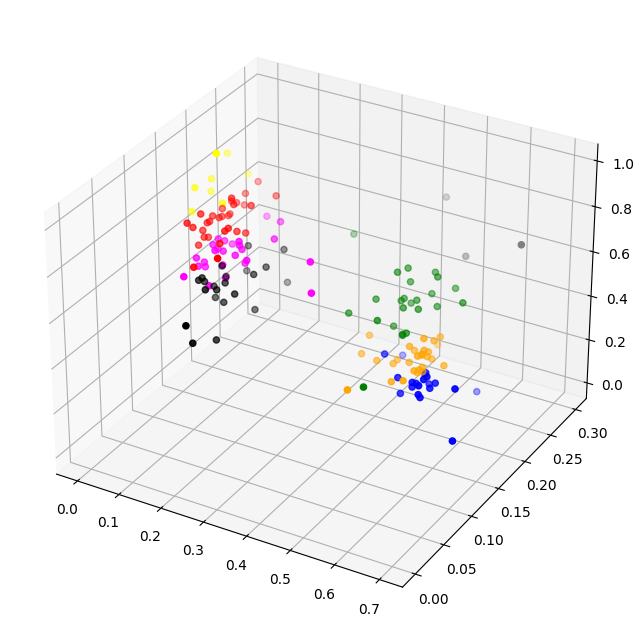

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(df2_0.attack_range, df2_0.max_attack_damage, df2_0.max_attack_speed, color = 'green')
ax.scatter3D(df2_1.attack_range, df2_1.max_attack_damage, df2_1.max_attack_speed, color = 'red')
ax.scatter3D(df2_2.attack_range, df2_2.max_attack_damage, df2_2.max_attack_speed, color = 'blue')
ax.scatter3D(df2_3.attack_range, df2_3.max_attack_damage, df2_3.max_attack_speed, color = 'black')
ax.scatter3D(df2_4.attack_range, df2_4.max_attack_damage, df2_4.max_attack_speed, color = 'gray')
ax.scatter3D(df2_5.attack_range, df2_5.max_attack_damage, df2_5.max_attack_speed, color = 'yellow')
ax.scatter3D(df2_6.attack_range, df2_6.max_attack_damage, df2_6.max_attack_speed, color = 'magenta')
ax.scatter3D(df2_7.attack_range, df2_7.max_attack_damage, df2_7.max_attack_speed, color = 'orange')




In addition, these champions have potential for attack speed based build :

In [41]:
df2.loc[df["cluster"] == 5]

,base_max_dps,max_attack_damage,max_attack_speed,attack_range,cluster
DrMundo,0.819278,0.205340,0.782620,0.000000,5
Ekko,0.637804,0.171845,0.704264,0.000000,5
Gnar,0.828343,0.168932,1.000000,0.066667,5
Malphite,0.972901,0.233010,0.841424,0.000000,5
Maokai,0.773405,0.204175,0.727843,0.000000,5
Sejuani,0.934010,0.244660,0.740957,0.033333,5
Shen,0.724863,0.177670,0.798447,0.000000,5
Yasuo,0.700415,0.177670,0.763475,0.066667,5


## K-means algorithm, tank stats of champions
### finding K

[8.008242269719634, 2.768817161947615, 2.044380314024238, 1.5582975816502889, 1.22092201989947, 1.0356236611106446, 0.8701819294008097, 0.7354564765218607, 0.6227365319720747, 0.5452748397075783, 0.4760915773678511, 0.4362837233921409, 0.3991544235157328, 0.35878381513784807, 0.3205741932178461, 0.2948994267575345, 0.26731610812972767, 0.2455566859083586, 0.227035747891158, 0.21347069757683743, 0.1900879029524261, 0.18141983050991517, 0.1675843958265953, 0.1642733654264044, 0.14930905836687497, 0.14509818445848388, 0.13801700517425727, 0.13241722093411984, 0.12377311364867224]


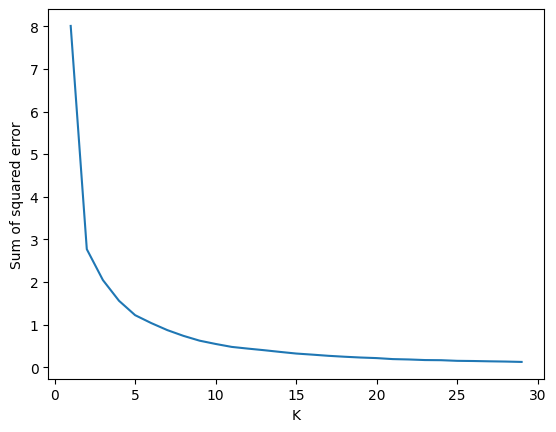

In [44]:
k_range = range(1,30)
sse =[]
for k in k_range:
    km = KMeans(n_clusters=k)
    #km.fit(df[["max_health","max_mana", "max_armor", "max_magic_resist", "max_attack_damage", "max_attack_speed"]])
    km.fit(df[["base_max_physical_effective_health", "base_max_magical_effective_health"]])
    sse.append(km.inertia_)

plt.xlabel("K")
plt.ylabel("Sum of squared error")
plt.plot(k_range,sse)
print(sse)

## K means algorithm
K = 7

In [45]:
km = KMeans(n_clusters=7)

prediction = km.fit_predict(df[["base_max_physical_effective_health", "base_max_magical_effective_health"]])

df["cluster_tank"] = prediction

df_tank = df[["base_max_physical_effective_health", "base_max_magical_effective_health", "cluster_tank"]]

In [46]:
df_tank.loc[df["cluster_tank"] == 0]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Aatrox,0.826365,0.708827,0
Akali,0.723893,0.817721,0
Alistar,0.982638,0.775606,0
Braum,1.000000,0.668322,0
Darius,0.960861,0.709922,0
Galio,0.804196,0.810637,0
Gragas,0.854978,0.673248,0
Gwen,0.904924,0.645880,0
Illaoi,0.852461,0.665585,0
Irelia,0.896060,0.724855,0


In [47]:
df_tank.loc[df["cluster_tank"] == 1]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Ahri,0.531590,0.231602,1
Akshan,0.599099,0.315214,1
Anivia,0.618409,0.223070,1
Annie,0.660876,0.285353,1
Aphelios,0.568396,0.279381,1
Ashe,0.644259,0.297724,1
Brand,0.611296,0.283646,1
Cassiopeia,0.603598,0.354484,1
Ezreal,0.632638,0.287912,1
Heimerdinger,0.494379,0.262743,1


In [48]:
df_tank.loc[df["cluster_tank"] == 2]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Blitzcrank,0.841170,0.571574,2
Camille,0.771403,0.567059,2
Evelynn,0.735096,0.555564,2
Graves,0.735386,0.620701,2
Hecarim,0.802221,0.555564,2
JarvanIV,0.767218,0.610301,2
Katarina,0.738128,0.665038,2
Kayn,0.800246,0.665038,2
LeeSin,0.810502,0.622343,2
Leona,0.862975,0.585670,2


In [49]:
df_tank.loc[df["cluster_tank"] == 3]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
AurelionSol,0.646394,0.336118,3
Azir,0.619899,0.420583,3
Bard,0.816264,0.307962,3
Caitlyn,0.693993,0.315641,3
Corki,0.683465,0.304550,3
Draven,0.689806,0.334411,3
Elise,0.834730,0.360007,3
Fiddlesticks,0.770663,0.338250,3
Garen,0.672161,0.417866,3
Jayce,0.703558,0.334411,3


In [50]:
df_tank.loc[df["cluster_tank"] == 4]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Thresh,0.0,0.41845,4


In [51]:
df_tank.loc[df["cluster_tank"] == 5]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Amumu,0.558990,0.495354,5
Belveth,0.685491,0.547354,5
Chogath,0.714556,0.519438,5
Diana,0.696504,0.656827,5
DrMundo,0.655421,0.608112,5
Ekko,0.629811,0.571985,5
Fiora,0.698333,0.552828,5
Fizz,0.640841,0.628912,5
Gangplank,0.697892,0.681459,5
Ivern,0.660519,0.571985,5


In [52]:
df_tank.loc[df["cluster_tank"] == 6]

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Gnar,0.393194,0.095519,6
Janna,0.569861,0.144577,6
Kayle,0.539155,0.098917,6
Orianna,0.513796,0.231555,6
Senna,0.549843,0.163774,6
Sona,0.489080,0.186810,6
Yuumi,0.438161,0.000000,6
Zyra,0.534540,0.211552,6


Text(0, 0.5, 'effective magical health')

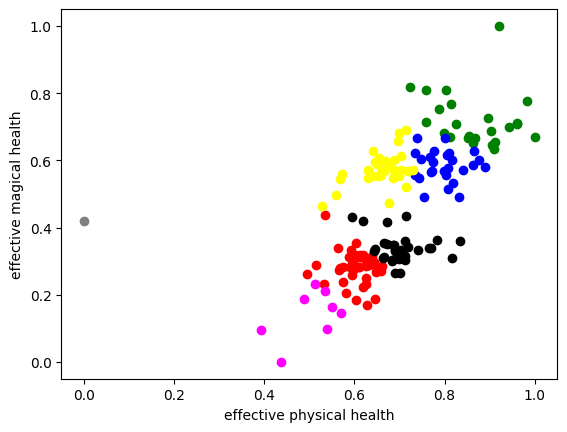

In [56]:
df_tank_0 = df_tank[df_tank.cluster_tank == 0]
df_tank_1 = df_tank[df_tank.cluster_tank == 1]
df_tank_2 = df_tank[df_tank.cluster_tank == 2]
df_tank_3 = df_tank[df_tank.cluster_tank == 3]
df_tank_4 = df_tank[df_tank.cluster_tank == 4]
df_tank_5 = df_tank[df_tank.cluster_tank == 5]
df_tank_6 = df_tank[df_tank.cluster_tank == 6]



plt.scatter(df_tank_0.base_max_physical_effective_health, df_tank_0.base_max_magical_effective_health, color = 'green')
plt.scatter(df_tank_1.base_max_physical_effective_health, df_tank_1.base_max_magical_effective_health, color = 'red')
plt.scatter(df_tank_2.base_max_physical_effective_health, df_tank_2.base_max_magical_effective_health, color = 'blue')
plt.scatter(df_tank_3.base_max_physical_effective_health, df_tank_3.base_max_magical_effective_health, color = 'black')
plt.scatter(df_tank_4.base_max_physical_effective_health, df_tank_4.base_max_magical_effective_health, color = 'gray')
plt.scatter(df_tank_5.base_max_physical_effective_health, df_tank_5.base_max_magical_effective_health, color = 'yellow')
plt.scatter(df_tank_6.base_max_physical_effective_health, df_tank_6.base_max_magical_effective_health, color = 'magenta')

plt.xlabel('effective physical health')
plt.ylabel('effective magical health')


The isolated champion on the left is Thresh, because his armor does not scale with level.\
The tankiest champions are not only tanks, but bruiser, assassin, and support as well because they need some survavibility without buying tank items.\
Sylas is the tankiest champion, and can perhaps be an effective tank due to the cc and utility he provides

In [59]:
df_tank_0

,base_max_physical_effective_health,base_max_magical_effective_health,cluster_tank
Aatrox,0.826365,0.708827,0
Akali,0.723893,0.817721,0
Alistar,0.982638,0.775606,0
Braum,1.000000,0.668322,0
Darius,0.960861,0.709922,0
Galio,0.804196,0.810637,0
Gragas,0.854978,0.673248,0
Gwen,0.904924,0.645880,0
Illaoi,0.852461,0.665585,0
Irelia,0.896060,0.724855,0
